<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/ClassificationTrainNVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook trains a RealNVP to fit the latent space posterior of uncorrupted data. This ensures that the prior distribution is actually Gaussian (corresponding to the prior distribution of the RealNVP).**

**In the second half of this notebook, we explore the root mean square difference between input and generator as a function of the data amplitude (pixel values).**

**This notebook also produces samples from the LAE flow prior to fitting the NVP**



In [192]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [0]:
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [0]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip
import corner

     - 8.0MB 1.4MB/s


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

In [0]:
generator_path   = './gdrive/My Drive/InjectiveFlow/modules/decoder1/decoder'
encoder_path     = './gdrive/My Drive/InjectiveFlow/modules/encoder1/encoder'
nvp_func_path    = './gdrive/My Drive/InjectiveFlow/modules/nvp1/'
class_nvp_path   = './gdrive/My Drive/InjectiveFlow/modules/nvp_by_class/'
plot_path        = './gdrive/My Drive/InjectiveFlow/semi-supervised/plots/'
loss_path        = './gdrive/My Drive/InjectiveFlow/semi-supervised/losses/'

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
data_dim    = 28*28
batch_size  = 128
hidden_size = 10
n_channels  = 1
sigma_n     = 0.1
sample_size_z = 64
label = 'class_nvp'

In [217]:
tf.reset_default_graph()


lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
nvp           = hub.Module(nvp_func_path, trainable=False)

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)


def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros([hidden_size]), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()
# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

mu            = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood        = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
nvp_samples       = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':prior_sample},as_dict=True)['fwd_pass']
sample_liklogits  = tf.reshape(generator(nvp_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# # -----------train NVP ----------------------#

nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]


def get_nvp():
  
  p1 = np.arange(0,hidden_size//2)
  p2 = np.arange(hidden_size//2,hidden_size)
  perm=np.concatenate((p2,p1))
  
  base_dis = get_prior()
  
  chain = []
  
  for i,s in enumerate(nvp_size):
    chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
    chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

  nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
  return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)

nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

loss      = -tf.reduce_mean(nvp_funcs({'z_sample':mu,'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])
opt_op_nvp= optimizer.minimize(loss)

# ---------------------------end train nvp ----------------- #

#comment train nvp above section above and uncomment this for loading the trained module



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0601 23:55:10.019934 140260369635200 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0601 23:55:10.198223 140260369635200 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0601 23:55:10.556791 140260369635200 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0601 23:55:10.757393 140260369635200 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0601 23:55:13.304862 140260369635200 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Training of the NVP**

In [0]:
nvp_loss = []
data_class = 9


In [220]:
indices = np.where(targets_train==data_class)
x_train_class = x_train[indices]
print(len(x_train_class))

4988


In [224]:
ii     = 0
nepoch = 0
learning_rate = 2e-5

#train the nvp
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train_class): 
    np.random.shuffle(x_train_class)
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>100:
    learning_rate=1e-5
  if nepoch>200:
    learning_rate=1e-6
  x_truth = x_train_class[batch_size*ii:batch_size*(ii+1)]
  sess.run([loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  nvp_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1
  if np.mean(nvp_loss[::-100])<12.0:
    break
print(np.mean(nvp_loss[::-100]))

13.183992
starting epoch 1
12.602549
starting epoch 2
12.993621
starting epoch 3
12.769333
starting epoch 4
12.805206
starting epoch 5
13.065415
starting epoch 6
12.797157
starting epoch 7
12.722979
starting epoch 8
13.188467
starting epoch 9
13.093082
starting epoch 10
12.632542
starting epoch 11
13.047695
starting epoch 12
12.739815
starting epoch 13
13.28266
starting epoch 14
12.788872
starting epoch 15
12.989771
starting epoch 16
13.048788
starting epoch 17
13.261458
starting epoch 18
12.978948
starting epoch 19
13.083018
starting epoch 20
12.8768835
starting epoch 21
13.019506
starting epoch 22
12.76117
starting epoch 23
12.945589
starting epoch 24
12.95326
starting epoch 25
12.84434
starting epoch 26
12.684368
starting epoch 27
13.163324
starting epoch 28
12.856668
starting epoch 29
13.006744
starting epoch 30
12.972992
starting epoch 31
12.729567
starting epoch 32
12.961951
starting epoch 33
12.630022
starting epoch 34
12.670285
starting epoch 35
12.845781
starting epoch 36
12.7

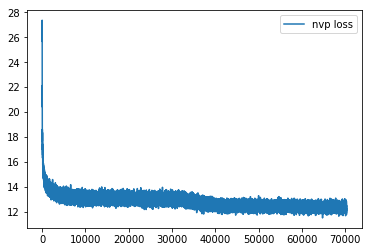

In [225]:
plt.figure()
plot(nvp_loss[::],label='nvp loss')
legend()
plt.savefig(plot_path+'loss_%d.png'%data_class, bbox_inches='tight')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 00:09:59.309327 140260369635200 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 00:10:00.468575 140260369635200 saver.py:1483] Saver not created because there are no variables in the graph to restore


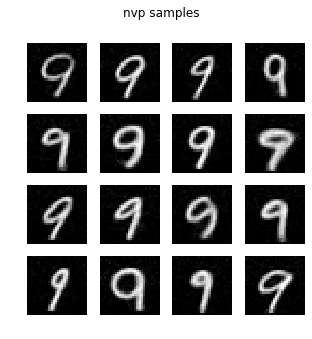

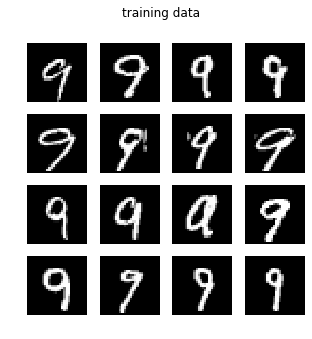

In [227]:
samples_nvp = sess.run(nvp_funcs({'z_sample':mu,'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])
s           = sess.run(tf.reshape(generator(samples_nvp),[-1,data_dim,n_channels]))

figure(figsize=(5,5))
suptitle('nvp samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.savefig(plot_path+'nvp_samples_%d.png'%data_class, bbox_inches='tight')

figure(figsize=(5,5))
suptitle('training data')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(x_train_class[i,:],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.savefig(plot_path+'training_data_%d.png'%data_class, bbox_inches='tight')

In [0]:
import pickle
nvp_funcs.export(class_nvp_path,sess)
pickle.dump(nvp_loss, open(loss_path+'class%d.pkl'%data_class,'wb'))

In [0]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':mu,'sample_size':20000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0601 21:48:48.550131 140260369635200 saver.py:1483] Saver not created because there are no variables in the graph to restore


(20000, 10)


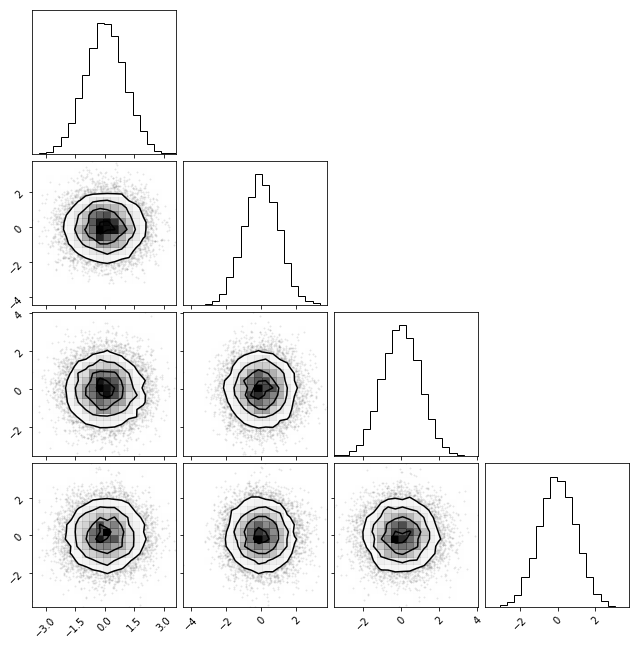

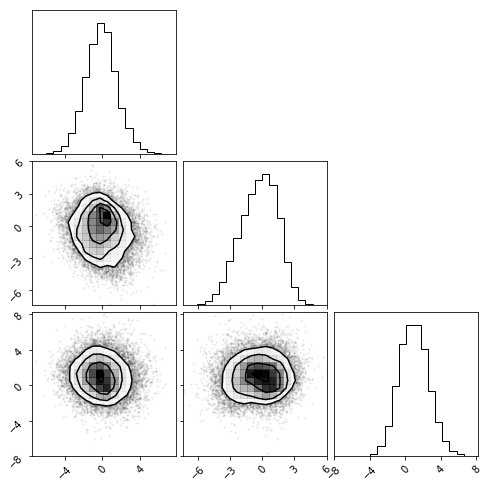

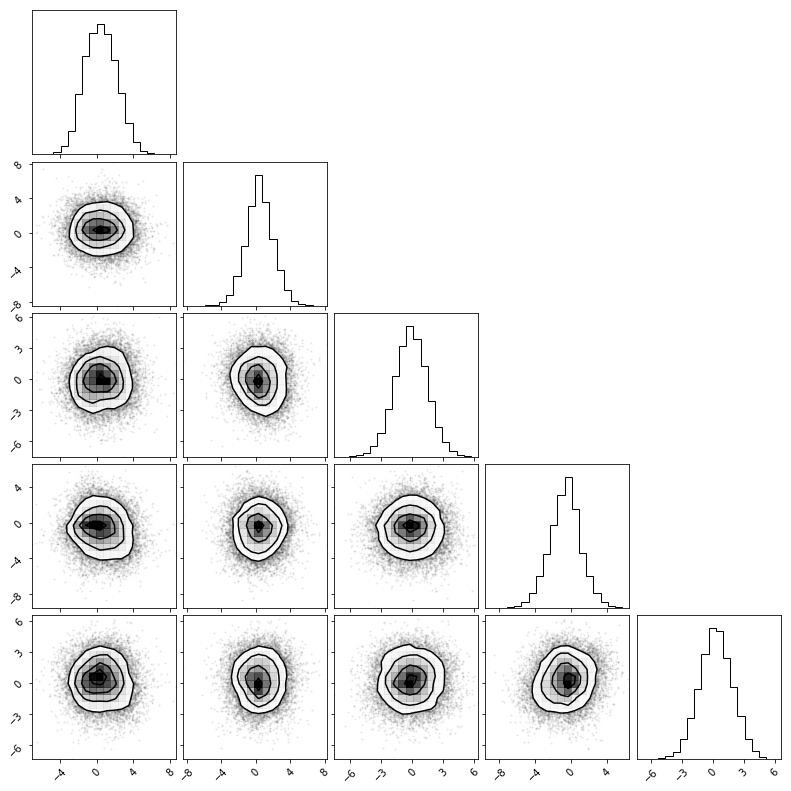

In [0]:
# plot contours of the prior
_ = corner.corner(prior_s[:,5:-1])
plt.savefig(plot_path+'prior_contours_%s.png'%label, bbox_inches='tight')
# plot comtours of the posterior distribution, fitten by the RealNVP
_ = corner.corner(maf_s[:,6:9])
plt.savefig(plot_path+'nvp_fitted_posterior_contours_%s.png'%label, bbox_inches='tight')
_ = corner.corner(maf_s[:,0:5])